In [1]:
# ==============================================================================
# SCRIPT TO CALCULATE AND PLOT FIGURE C1 (Pressure-Coordinate Version, Comparing Saturation Vapor Pressure Formulations)
#
# This script performs the following actions:
# 1. Defines thermodynamic constants and functions for a moist atmosphere using different saturation vapor pressure formulations: Bolton, Goff-Gratch, and Murphy-Koop.
# 2. Implements functions to calculate moist adiabatic temperature profiles T(p) for each formulation (without fusion).
# 3. Runs these functions for a dense range of surface temperatures (Ts) and perturbed states to compute warming profiles for each.
# 4. Processes the results to find peak T_s for each pressure level in each case.
# 5. Creates a two-panel plot:
#    (a) Peak T_s for Bolton (x) vs. Goff-Gratch (y), colored by pressure.
#    (b) Peak T_s for Bolton (x) vs. Murphy-Koop (y), colored by pressure.
# ==============================================================================

%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv = 2.501e6

# --- Saturation Vapor Pressure Functions ---

def saturation_vapor_pressure_bolton(T):
    """
    Calculates saturation vapor pressure (es) over liquid water using the
    formula from Bolton (1980) (in Pa).
    """
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_vapor_pressure_goff(T):
    """
    Calculates saturation vapor pressure (es) over liquid water using the
    Goff-Gratch formula (1946) (in Pa).
    """
    term1 = -7.90298 * (373.16 / T - 1)
    term2 = 5.02808 * np.log10(373.16 / T)
    term3 = -1.3816e-7 * (10**(11.344 * (1 - T / 373.16)) - 1)
    term4 = 8.1328e-3 * (10**(-3.49149 * (373.16 / T - 1)) - 1)
    term5 = np.log10(1013.246)
    log10_ew = term1 + term2 + term3 + term4 + term5
    ew_hPa = 10**log10_ew
    return ew_hPa * 100.0  # to Pa

def saturation_vapor_pressure_murphy(T):
    """
    Calculates saturation vapor pressure (es) over liquid water using the
    Murphy-Koop formula (2005) (in Pa).
    """
    ln_ew = 54.842763 - 6763.22 / T - 4.210 * np.log(T) + 0.000367 * T + \
            np.tanh(0.0415 * (T - 218.8)) * (53.878 - 1331.22 / T - 9.44523 * np.log(T) + 0.014025 * T)
    ew = np.exp(ln_ew)
    return ew

# --- General Thermodynamic Functions (parameterized by svp_func) ---

def saturation_specific_humidity(p, T, svp_func):
    """Calculates saturation specific humidity (qs) (kg/kg)."""
    es = svp_func(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    qs = epsilon * es / denominator
    return np.maximum(qs, 1e-9)

def virtual_temperature(T, p, svp_func):
    """Calculates virtual temperature (Tv) assuming saturation."""
    qs = saturation_specific_humidity(p, T, svp_func)
    Tv = T * (1.0 + (1.0 / epsilon - 1.0) * qs)
    return np.maximum(Tv, 10.0)

def calculate_mse(T, p, z, svp_func):
    """Calculates Moist Static Energy (MSE) (J/kg)."""
    qs = saturation_specific_humidity(p, T, svp_func)
    mse = cpd * T + g * z + Lv * qs
    return mse

def calculate_profile(T_surf, p_surf, p_grid, svp_func):
    """
    Calculates T(p) by conserving MSE at each pressure step.
    Returns the temperature profile on the p_grid.
    """
    n_steps = len(p_grid)
    T_profile = np.full(n_steps, np.nan)
    z_profile = np.full(n_steps, np.nan)
    T_profile[0] = T_surf
    z_profile[0] = 0.0
    mse_conserved = calculate_mse(T_profile[0], p_grid[0], z_profile[0], svp_func)
    for i in range(n_steps - 1):
        T_curr, p_curr, z_curr = T_profile[i], p_grid[i], z_profile[i]
        p_next = p_grid[i+1]
        if np.isnan(T_curr) or p_curr <= 0: break
        Tv_curr = virtual_temperature(T_curr, p_curr, svp_func)
        alpha_curr = (Rd * Tv_curr) / p_curr
        dz = - (alpha_curr / g) * (p_next - p_curr)
        z_next = z_curr + dz
        
        def mse_residual(T_guess):
            return calculate_mse(T_guess, p_next, z_next, svp_func) - mse_conserved
        
        try:
            bracket = [150.0, T_curr + 10.0]
            if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0:
                bracket[1] += 20.0
                if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0: break
            sol = root_scalar(mse_residual, bracket=bracket, method='brentq', xtol=1e-3)
            if sol.converged:
                T_profile[i+1] = sol.root
                z_profile[i+1] = z_next
            else: break
        except (ValueError, RuntimeError): break
    return T_profile

# --- Helper Function for Finding Interpolated Roots (for maxima) ---

def find_interpolated_root(y_slice, x_vals, y_slice_for_guess=None, guess_mode='max', guess_T=None):
    """
    Finds the interpolated root(s) of y_slice (gradient) and selects the best one.
    Only considers crossings from positive to negative (local maxima).
    If guess_T is provided, selects the candidate closest to guess_T.
    Otherwise, uses discrete min/max/abs_min as guess.
    """
    if np.all(np.isnan(y_slice)):
        return np.nan

    # Find sign changes
    sign_changes = np.where((y_slice[:-1] * y_slice[1:]) < 0)[0]
    
    k_all = []
    for k in sign_changes:
        if np.isfinite(y_slice[k]) and np.isfinite(y_slice[k+1]):
            k_all.append(k)
    
    if not k_all:
        return np.nan

    # Interpolate candidate roots, but only for maxima (+ to -)
    T_candidates = []
    for k in k_all:
        y0, y1 = y_slice[k], y_slice[k+1]
        if y0 > 0 and y1 < 0:  # Gradient crossing from + to - indicates maximum
            T0, T1 = x_vals[k], x_vals[k+1]
            if y1 == y0: continue
            T_root = T0 - y0 * (T1 - T0) / (y1 - y0)
            T_candidates.append(T_root)

    if not T_candidates:
        return np.nan
    
    if len(T_candidates) == 1:
        return T_candidates[0]

    # Select based on guess_T if provided
    if guess_T is not None:
        return min(T_candidates, key=lambda T: abs(T - guess_T))

    # Otherwise, use discrete guess
    if y_slice_for_guess is None:
        y_slice_for_guess = y_slice
    
    if guess_mode == 'max':
        j_guess = np.nanargmax(y_slice_for_guess)
    elif guess_mode == 'min':
        j_guess = np.nanargmin(y_slice_for_guess)
    elif guess_mode == 'abs_min':
        j_guess = np.nanargmin(np.abs(y_slice_for_guess))
    else:
        raise ValueError("Invalid guess_mode")
    
    T_guess = x_vals[j_guess]
    return min(T_candidates, key=lambda T: abs(T - T_guess))

# --- Main Calculation Block ---
print("--- Starting Main Calculation (Comparing SVP Formulations) ---")
start_time = time.time()

# Parameters
T_surf_vals = np.arange(270, 320.1, 0.5)
n_t = len(T_surf_vals)
p_surf_pa = 100000.0
p_top_pa = 10000.0
dp_pa = -50.0
p_grid = np.arange(p_surf_pa, p_top_pa + dp_pa, dp_pa)
n_p = len(p_grid)
delta_T_surf = 4.0

# Storage grids
delta_T_grid_bolton = np.full((n_p, n_t), np.nan)
delta_T_grid_goff = np.full((n_p, n_t), np.nan)
delta_T_grid_murphy = np.full((n_p, n_t), np.nan)

for j, T_s in enumerate(T_surf_vals):
    print(f"Processing Ts = {T_s:.1f} K...")
    
    # Bolton
    T1_bolton = calculate_profile(T_s, p_surf_pa, p_grid, saturation_vapor_pressure_bolton)
    T2_bolton = calculate_profile(T_s + delta_T_surf, p_surf_pa, p_grid, saturation_vapor_pressure_bolton)
    if not np.isnan(T1_bolton[-1]) and not np.isnan(T2_bolton[-1]):
        delta_T_grid_bolton[:, j] = T2_bolton - T1_bolton
    
    # Goff-Gratch
    T1_goff = calculate_profile(T_s, p_surf_pa, p_grid, saturation_vapor_pressure_goff)
    T2_goff = calculate_profile(T_s + delta_T_surf, p_surf_pa, p_grid, saturation_vapor_pressure_goff)
    if not np.isnan(T1_goff[-1]) and not np.isnan(T2_goff[-1]):
        delta_T_grid_goff[:, j] = T2_goff - T1_goff
    
    # Murphy-Koop
    T1_murphy = calculate_profile(T_s, p_surf_pa, p_grid, saturation_vapor_pressure_murphy)
    T2_murphy = calculate_profile(T_s + delta_T_surf, p_surf_pa, p_grid, saturation_vapor_pressure_murphy)
    if not np.isnan(T1_murphy[-1]) and not np.isnan(T2_murphy[-1]):
        delta_T_grid_murphy[:, j] = T2_murphy - T1_murphy

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

# --- Find Peak T_s for Each Pressure Level ---
print("--- Finding Peak T_s for Each Pressure Level ---")
start_time = time.time()

peak_Ts_bolton = np.full(n_p, np.nan)
peak_Ts_goff = np.full(n_p, np.nan)
peak_Ts_murphy = np.full(n_p, np.nan)
dT_s = T_surf_vals[1] - T_surf_vals[0]

for i in range(n_p):
    # Bolton
    warming_slice_bolton = delta_T_grid_bolton[i, :]
    if np.all(np.isnan(warming_slice_bolton)): continue
    grad_slice_bolton = np.gradient(warming_slice_bolton, dT_s)
    peak_Ts_bolton[i] = find_interpolated_root(grad_slice_bolton, T_surf_vals, y_slice_for_guess=warming_slice_bolton, guess_mode='max')
    
    # Goff-Gratch
    warming_slice_goff = delta_T_grid_goff[i, :]
    if np.all(np.isnan(warming_slice_goff)): continue
    grad_slice_goff = np.gradient(warming_slice_goff, dT_s)
    if not np.isnan(peak_Ts_bolton[i]):
        peak_Ts_goff[i] = find_interpolated_root(grad_slice_goff, T_surf_vals, guess_T=peak_Ts_bolton[i])
    
    # Murphy-Koop
    warming_slice_murphy = delta_T_grid_murphy[i, :]
    if np.all(np.isnan(warming_slice_murphy)): continue
    grad_slice_murphy = np.gradient(warming_slice_murphy, dT_s)
    if not np.isnan(peak_Ts_bolton[i]):
        peak_Ts_murphy[i] = find_interpolated_root(grad_slice_murphy, T_surf_vals, guess_T=peak_Ts_bolton[i])

# Set surface to NaN
peak_Ts_bolton[0] = np.nan
peak_Ts_goff[0] = np.nan
peak_Ts_murphy[0] = np.nan

print(f"\n--- Peak Finding Finished in {time.time() - start_time:.2f} seconds ---\n")


--- Starting Main Calculation (Comparing SVP Formulations) ---
Processing Ts = 270.0 K...
Processing Ts = 270.5 K...
Processing Ts = 271.0 K...
Processing Ts = 271.5 K...
Processing Ts = 272.0 K...
Processing Ts = 272.5 K...
Processing Ts = 273.0 K...
Processing Ts = 273.5 K...
Processing Ts = 274.0 K...
Processing Ts = 274.5 K...
Processing Ts = 275.0 K...
Processing Ts = 275.5 K...
Processing Ts = 276.0 K...
Processing Ts = 276.5 K...
Processing Ts = 277.0 K...
Processing Ts = 277.5 K...
Processing Ts = 278.0 K...
Processing Ts = 278.5 K...
Processing Ts = 279.0 K...
Processing Ts = 279.5 K...
Processing Ts = 280.0 K...
Processing Ts = 280.5 K...
Processing Ts = 281.0 K...
Processing Ts = 281.5 K...
Processing Ts = 282.0 K...
Processing Ts = 282.5 K...
Processing Ts = 283.0 K...
Processing Ts = 283.5 K...
Processing Ts = 284.0 K...
Processing Ts = 284.5 K...
Processing Ts = 285.0 K...
Processing Ts = 285.5 K...
Processing Ts = 286.0 K...
Processing Ts = 286.5 K...
Processing Ts = 287

--- Generating Figure C1 ---
Bolton-Goff 0.27024262211273253
at p= 992.0
Bolton-Murphy 0.3443394217850937
at p= 992.0


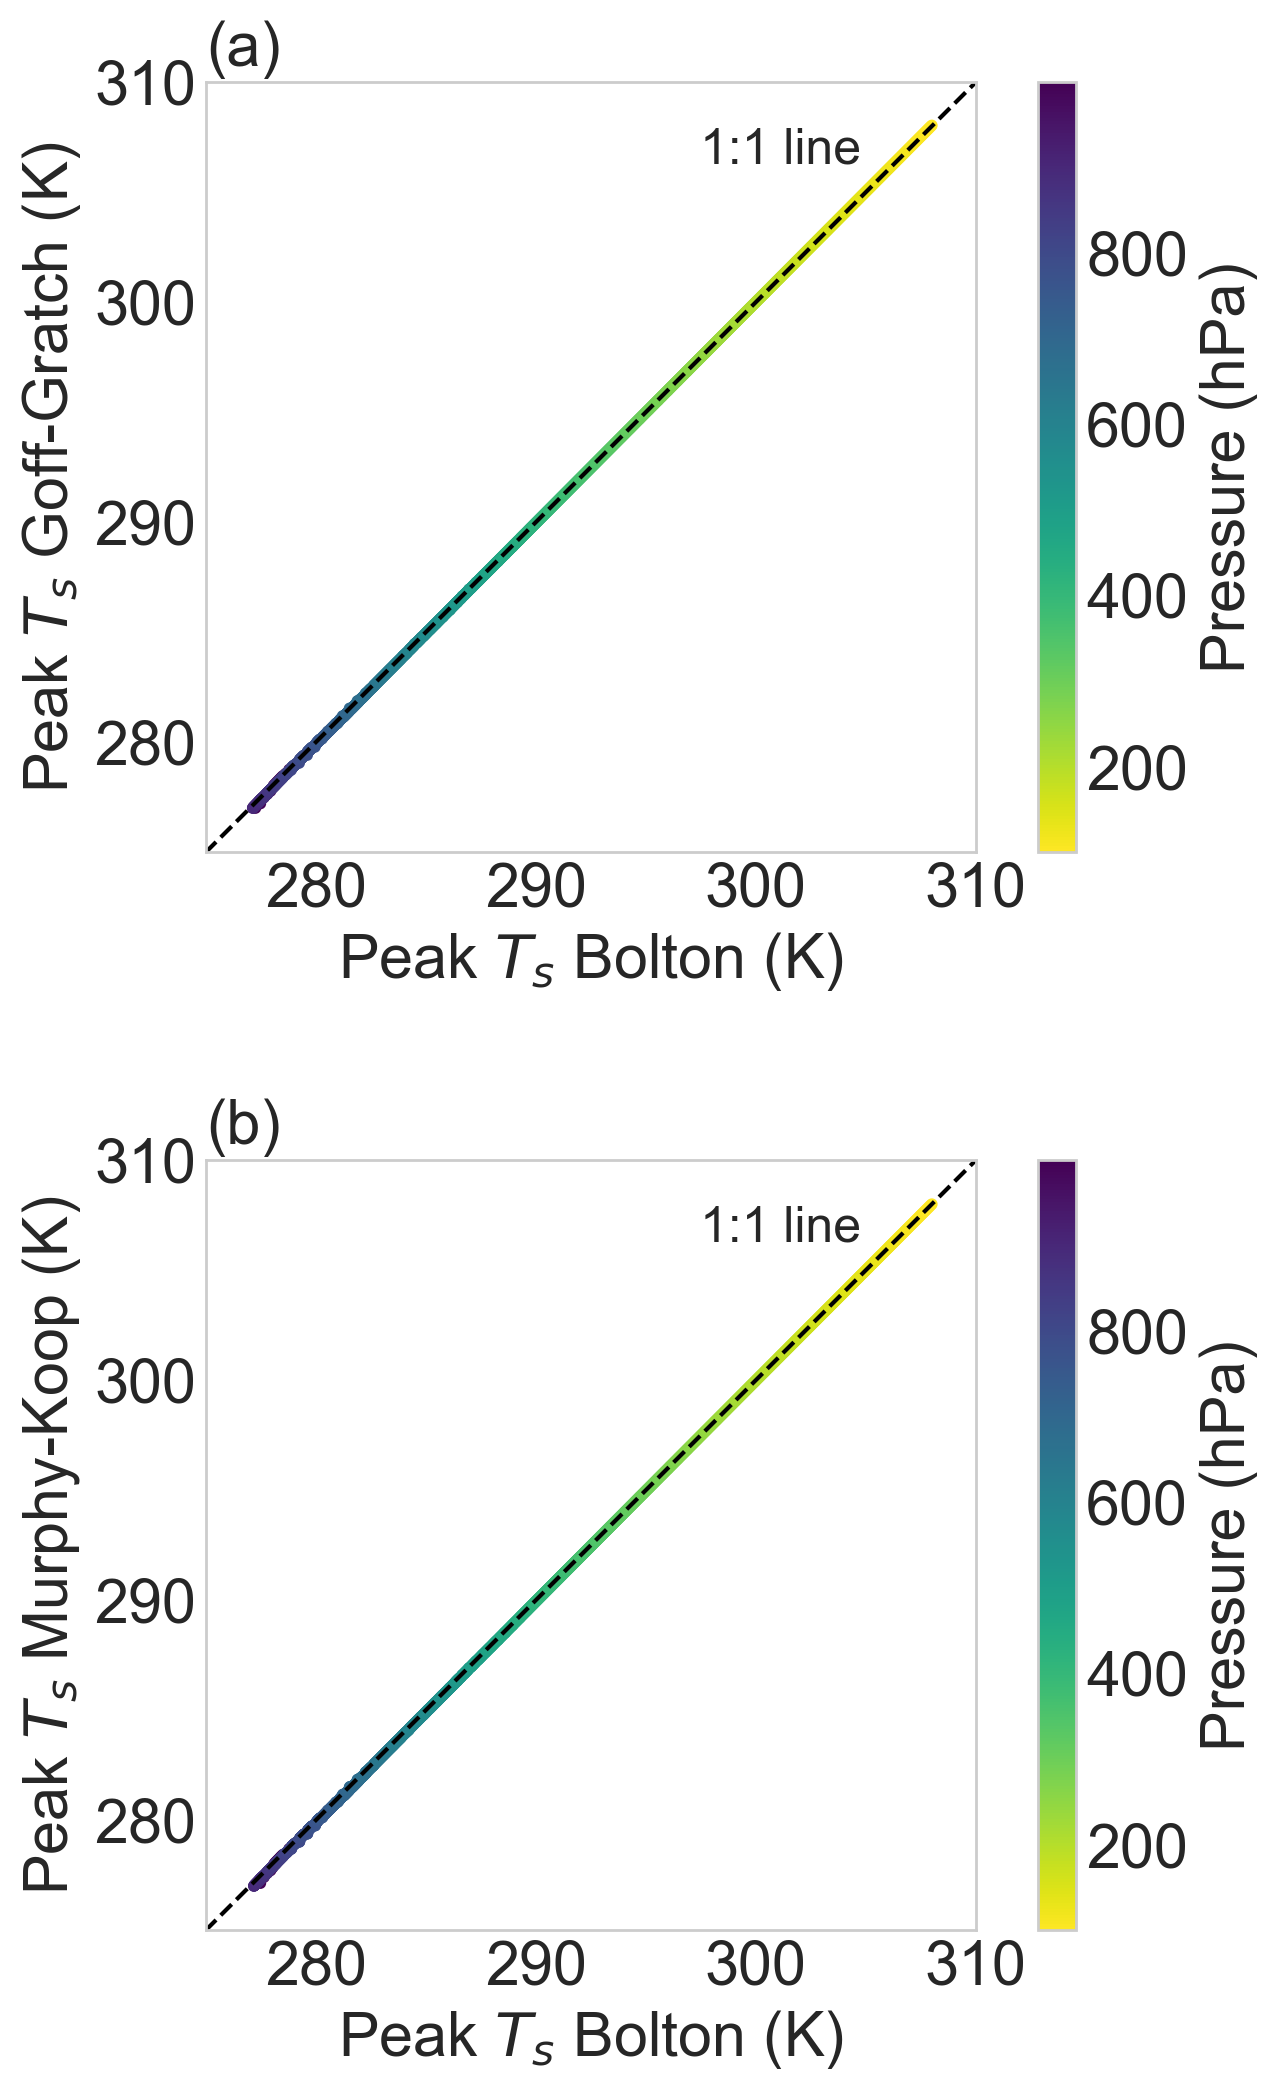

Figure C1 saved as fig-c1.png

Script finished.


In [2]:
# --- Plotting Figure C1 ---
print("--- Generating Figure C1 ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize,
    'axes.titlesize': base_fontsize,
    'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize,
    'legend.fontsize': base_fontsize-4,
    'figure.titlesize': base_fontsize + 2
})

fig, axes = plt.subplots(2, 1, figsize=(8, 12))
p_hpa_grid = p_grid / 100.0

# Panel (a): Peak T_s Bolton vs. Goff-Gratch, colored by pressure
ax1 = axes[0]
valid_idx = ~np.isnan(peak_Ts_bolton) & ~np.isnan(peak_Ts_goff)
p_hpa_valid = p_hpa_grid[valid_idx]
x = peak_Ts_bolton[valid_idx]
y = peak_Ts_goff[valid_idx]
print('Bolton-Goff', np.max(np.abs(x-y)))
print('at p=', p_hpa_valid[np.argmax(np.abs(x-y))])
sc1 = ax1.scatter(x, y, c=p_hpa_valid, cmap='viridis_r', s=10)
ax1.plot([270, 320], [270, 320], 'k--', label='1:1 line     ')
ax1.set_xlabel('Peak $T_{s}$ Bolton (K)')
ax1.set_ylabel('Peak $T_{s}$ Goff-Gratch (K)')
ax1.set_title('(a)', ha='left', x=0)
ax1.set_xlim(275, 310)
ax1.set_ylim(275, 310)
ax1.grid(False)
ax1.legend(frameon=False, loc='upper right', handletextpad=0.5, handlelength=0)
ax1.set_box_aspect(1)
cbar1 = fig.colorbar(sc1, ax=ax1, label='Pressure (hPa)')

# Panel (b): Peak T_s Bolton vs. Murphy-Koop, colored by pressure
ax2 = axes[1]
valid_idx = ~np.isnan(peak_Ts_bolton) & ~np.isnan(peak_Ts_murphy)
p_hpa_valid = p_hpa_grid[valid_idx]
x = peak_Ts_bolton[valid_idx]
y = peak_Ts_murphy[valid_idx]
print('Bolton-Murphy', np.max(np.abs(x-y)))
print('at p=', p_hpa_valid[np.argmax(np.abs(x-y))])
sc2 = ax2.scatter(x, y, c=p_hpa_valid, cmap='viridis_r', s=10)
ax2.plot([270, 320], [270, 320], 'k--', label='1:1 line     ')
ax2.set_xlabel('Peak $T_{s}$ Bolton (K)')
ax2.set_ylabel('Peak $T_{s}$ Murphy-Koop (K)')
ax2.set_title('(b)', ha='left', x=0)
ax2.set_xlim(275, 310)
ax2.set_ylim(275, 310)
ax2.grid(False)
ax2.legend(frameon=False, loc='upper right', handletextpad=0.5, handlelength=0)
ax2.set_box_aspect(1)
cbar2 = fig.colorbar(sc2, ax=ax2, label='Pressure (hPa)')

plt.subplots_adjust(hspace=0.4)
filename = "fig-c1.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure C1 saved as {filename}")
print("\nScript finished.")
